## Modelling and Predicting Cyber hacking Breaches using Time Series Analysis
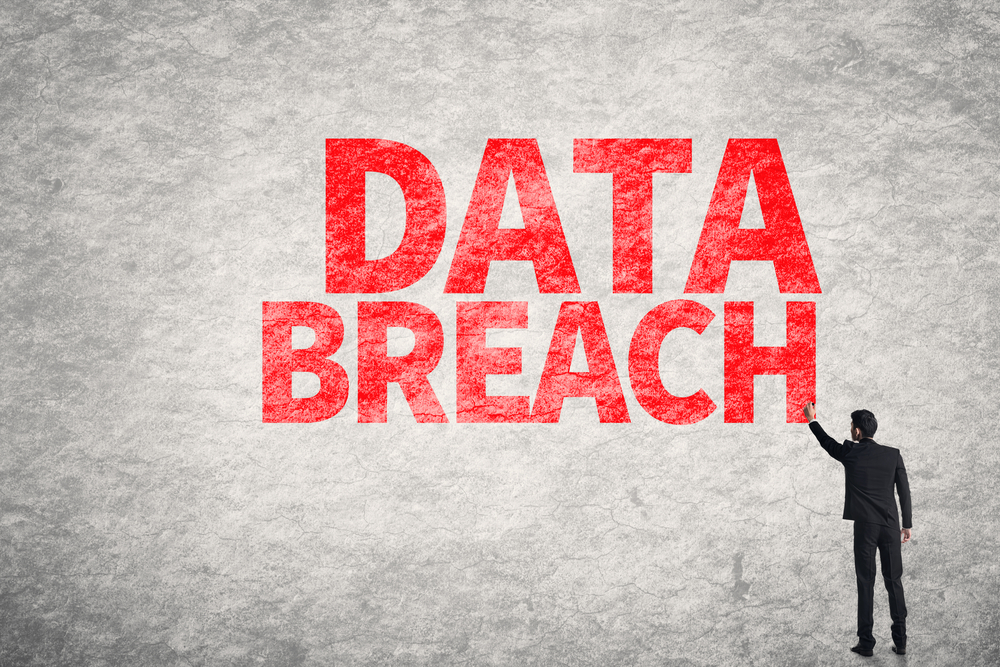

### Importing required libraries

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
warnings.filterwarnings(action='once')

### Loading Data
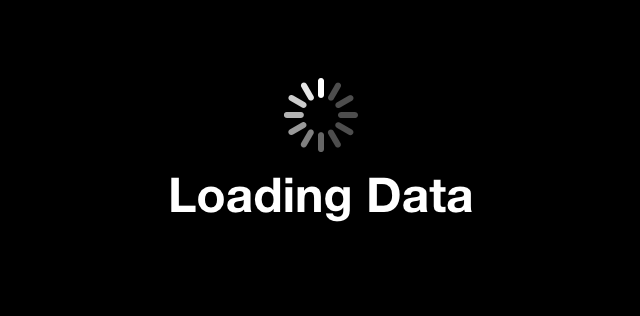

In [3]:
data=pd.read_csv("cyber_breach_data.csv")

In [4]:
data.head()

,Date Made Public,Company,City,State,Type of breach,Type of organization,Total Records,Description of incident,Information Source,Source URL,Year of Breach,Latitude,Longitude,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1-10-2005,George Mason University,Fairfax,Virginia,HACK,EDU,"32,000","Names, photos, and Social Security numbers of ...",Dataloss DB,NaN,2005.0,38.846224,-77.306373,NaN,NaN,NaN
1,1-18-2005,"University of California, San Diego",San Diego,California,HACK,EDU,"3,500",A hacker breached the security of two Universi...,Dataloss DB,NaN,2005.0,32.715329,-117.157255,NaN,NaN,NaN
2,1-22-2005,University of Northern Colorado,Greeley,Colorado,PORT,EDU,"15,790",A hard drive was lost or stolen. It contained ...,Dataloss DB,NaN,2005.0,40.423314,-104.709132,NaN,NaN,NaN
3,2-12-2005,Science Applications International Corp. (SAIC),San Diego,California,STAT,BSO,"45,000",On January 25 thieves broke \n into...,Dataloss DB,NaN,2005.0,32.715329,-117.157255,NaN,NaN,NaN
4,2-15-2005,ChoicePoint,Alpharetta,Georgia,INSD,BSO,"1,63,000",Fraudsters who presented themselves as legitim...,Security Breach Letter,NaN,2005.0,34.075376,-84.294090,NaN,NaN,NaN


### Preprocessing the Data
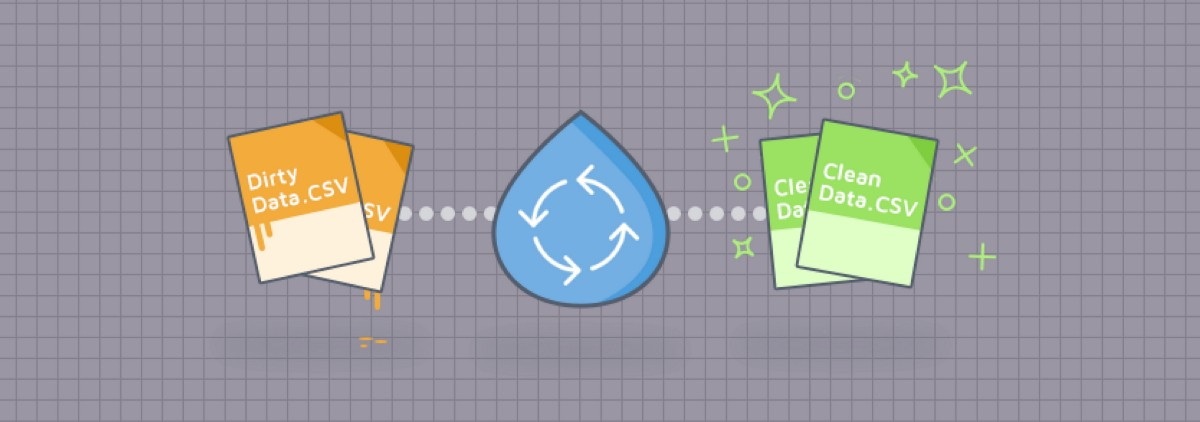

In [5]:
time_series=data.loc[data['Type of breach'] == "HACK", ["Date Made Public","Total Records","Type of breach"]]
time_series = time_series.dropna(subset=["Date Made Public"])
time_series["Total Records"]=time_series["Total Records"].str.replace(",","")
time_series["Total Records"] = pd.to_numeric(time_series["Total Records"], errors='coerce')
drop_indices=time_series["Total Records"][time_series["Total Records"]>30000].index
drop_index=time_series["Total Records"][time_series["Total Records"]==0].index
time_series=time_series.drop(drop_indices)
time_series=time_series.drop(drop_index)
time_series.index=range(1406)

In [6]:
time_series = time_series.groupby('Date Made Public')['Total Records'].sum().reset_index()
time_series = time_series.set_index('Date Made Public')
time_series.index = pd.to_datetime(time_series.index)
time_series.index

DatetimeIndex(['2019-08-11', '2019-08-15', '2019-08-16', '2019-08-22',
               '2019-08-23', '2019-08-27', '2019-08-29', '2019-08-30',
               '2019-09-03', '2019-09-06',
               ...
               '2006-09-07', '2011-09-07', '2017-09-07', '2018-09-07',
               '2010-09-08', '2014-09-08', '2016-09-08', '2017-09-08',
               '2014-09-09', '2015-09-09'],
              dtype='datetime64[ns]', name='Date Made Public', length=980, freq=None)

### Re-sampling the data

In [7]:
y = time_series['Total Records'].resample('MS').mean()
# time_series

### Original Plot of No.of.Breaches

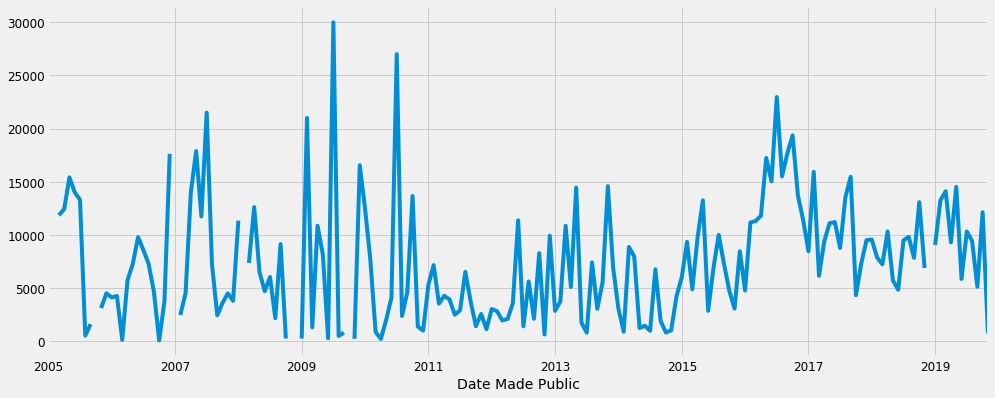

In [8]:
y.plot(figsize=(15, 6))
plt.show()

In [9]:
y=y.dropna()

### Using statistical methods to decompose data into seasonality and trend

C:\Users\tarun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


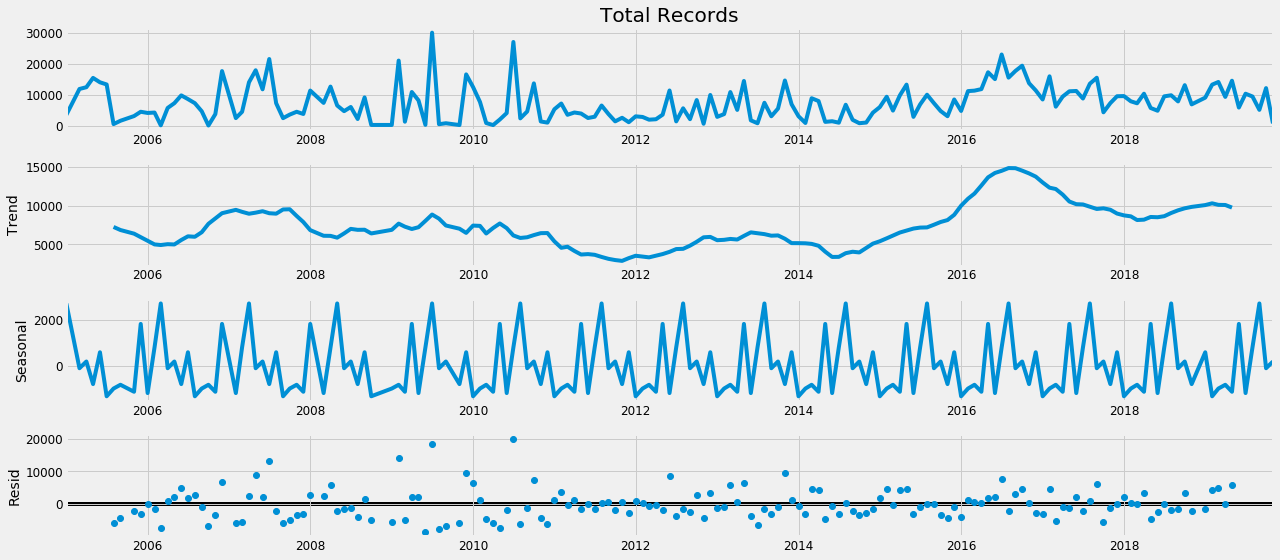

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y,freq=12, model='additive')
fig = decomposition.plot()
plt.show()

### Generating all possible p,d,q values to fit into ARIMA model

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Performing Grid search for optimal values
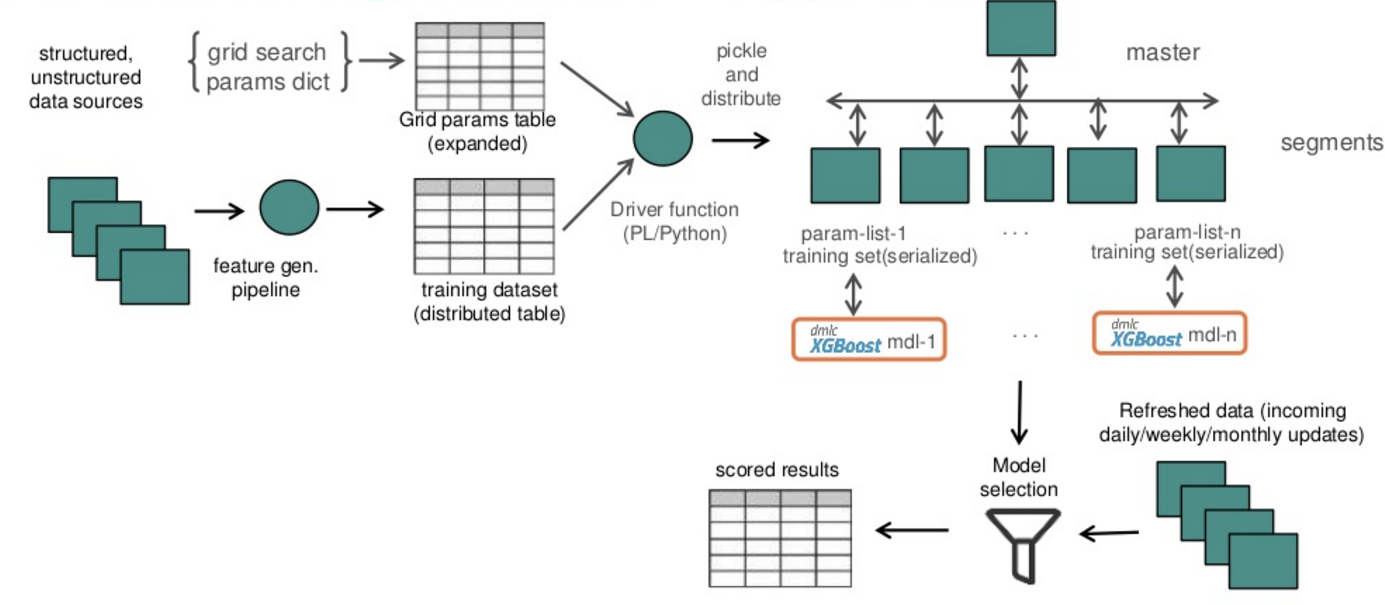

In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\tarun\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3591.518657843917
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3303.2203062165986
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3287.0243691413657
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2974.3106294140293
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3277.994601451446
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3217.5023939847215
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3019.588115458818
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2975.9956577541743
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3516.590014501854
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3262.064344006458
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3268.007928232962
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2963.6620910972297
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3291.488953570188
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3231.0114670117123
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3025.1105351636043
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2965.404817271934
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3478.5961941084315
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3237.483428618263
A

### Modelling the most optimal paramters

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

### Plotting the forecast of ARIMA model and observed results

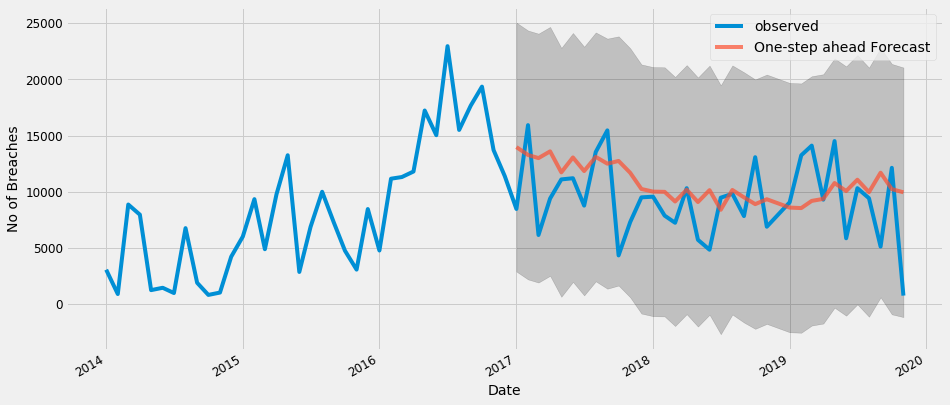

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('No of Breaches')
plt.legend()

plt.show()

### Evaluating the model using metrics using MSE, RMSE, MAE 
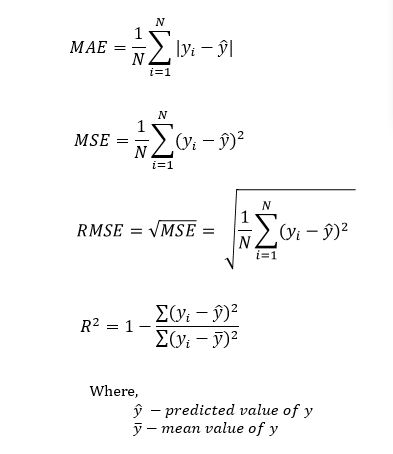

In [19]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 14725803.05


In [20]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3837.42


In [21]:
mean_error=(y_forecasted-y_truth).sum()/len(y_truth)
print('Mean Error:',mean_error)

Mean Error: 1394.8847794482656


In [11]:
from scipy.optimize import curve_fit